In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings('ignore')

#%matpltlib inline
sns.set(context='notebook', style='darkgrid', palette='deep', font='sans-serif', font_scale=2.5)

In [2]:
df_amazon=pd.read_csv("D:/从c盘转移的桌面/github/E-commerce Analysis Python Project/amazon.csv",encoding='gbk')

In [3]:
df_amazon.loc[df_amazon['price']==0,'price']=None
df_amazon.loc[df_amazon['rank_big']==0,'rank_big']=None
df_amazon.isnull().any()

class0        False
price          True
rank1_list    False
stars         False
reviews       False
delivery       True
rank_big       True
brand          True
stock         False
dtype: bool

In [4]:
df_amazon=df_amazon[df_amazon['stock']!='Currently unavailable.']
df_amazon.dropna(axis=0,how='any',subset=['brand','price','stock'],inplace=True)

In [5]:
p1=df_amazon['class0'].value_counts()
p2=list(p1[df_amazon['class0'].value_counts()>40].index)
#product price moren than 40
df_amazon=df_amazon[df_amazon['class0'].isin(p2)]

In [6]:
df_clean=df_amazon.copy()
df_clean['rank_big_up']=df_clean['rank_big']
df_clean['rank_big_down']=df_clean['rank_big']
df_clean['rank_big']=(df_clean['rank_big_up'].fillna(method='pad')+df_clean['rank_big_down'].fillna(method='backfill'))/2
df_clean['delivery']=df_clean['delivery'].fillna('none')

In [7]:
#Discretization and Binning of Continuous Variables
df_clean['rank1_list_cut']=df_clean['rank1_list'].apply(lambda x:'<=10' if x<=10 else ">10")
df_clean[['rank1_list','rank1_list_cut']]

,rank1_list,rank1_list_cut
0,1,<=10
1,2,<=10
2,3,<=10
3,4,<=10
4,5,<=10
...,...,...
541,46,>10
542,47,>10
543,48,>10
544,49,>10


In [8]:
reviews_bins= [0,50,100,300,1000,1500,2000,1000000]
reviews_labels = ['0-50','50-100','100-300','300-1000','1000-1500','1500-2000','>2000']
df_clean['reviews_cut']=pd.cut(df_clean['reviews'].apply(int),bins=reviews_bins,right=False,labels=reviews_labels)

In [9]:
price_bins= [0,20,40,60,80,100,120,140,160,180,1000000]
price_labels = ['0-20','20-40','40-60','60-80','80-100','100-120','120-140','140-160','160-180','>180']
df_clean['price_cut']=pd.cut(df_clean['price'].apply(int),bins=price_bins,right=False,labels=price_labels)

In [10]:
# stars
stars_bins = [0,1,2,3,4,5,6]
starts_labels = ['0-1','1-2','2-3','3-4','4-5','5']
df_clean['stars_cut']=pd.cut(df_clean['stars'].apply(float),bins=stars_bins,right=False,labels=starts_labels)

In [11]:
#rank
rank_bins=[0,500,1000,5000,10000,50000,100000,10000000]
rank_labels = ['0-500','500-1000','1000-5000','5000-10000','10000-50000','50000-100000','>100000']
df_clean['rank_big_cut']=pd.cut(df_clean['rank_big'].apply(float),bins=rank_bins,right=False,labels=rank_labels)

In [12]:
df_clean['price_cut_n']=df_clean['price_cut'].cat.codes+1
df_clean['reviews_cut_n']=7-df_clean['reviews_cut'].cat.codes
df_clean['price_cut_n']=df_clean['price_cut'].cat.codes+1
df_clean['stars_cut_n']=df_clean['stars_cut'].cat.codes+1
df_clean['rank_big_cut_n']=7-df_clean['rank_big_cut'].cat.codes
df_clean['r_p'] = df_clean['price_cut_n']*df_clean['reviews_cut_n']

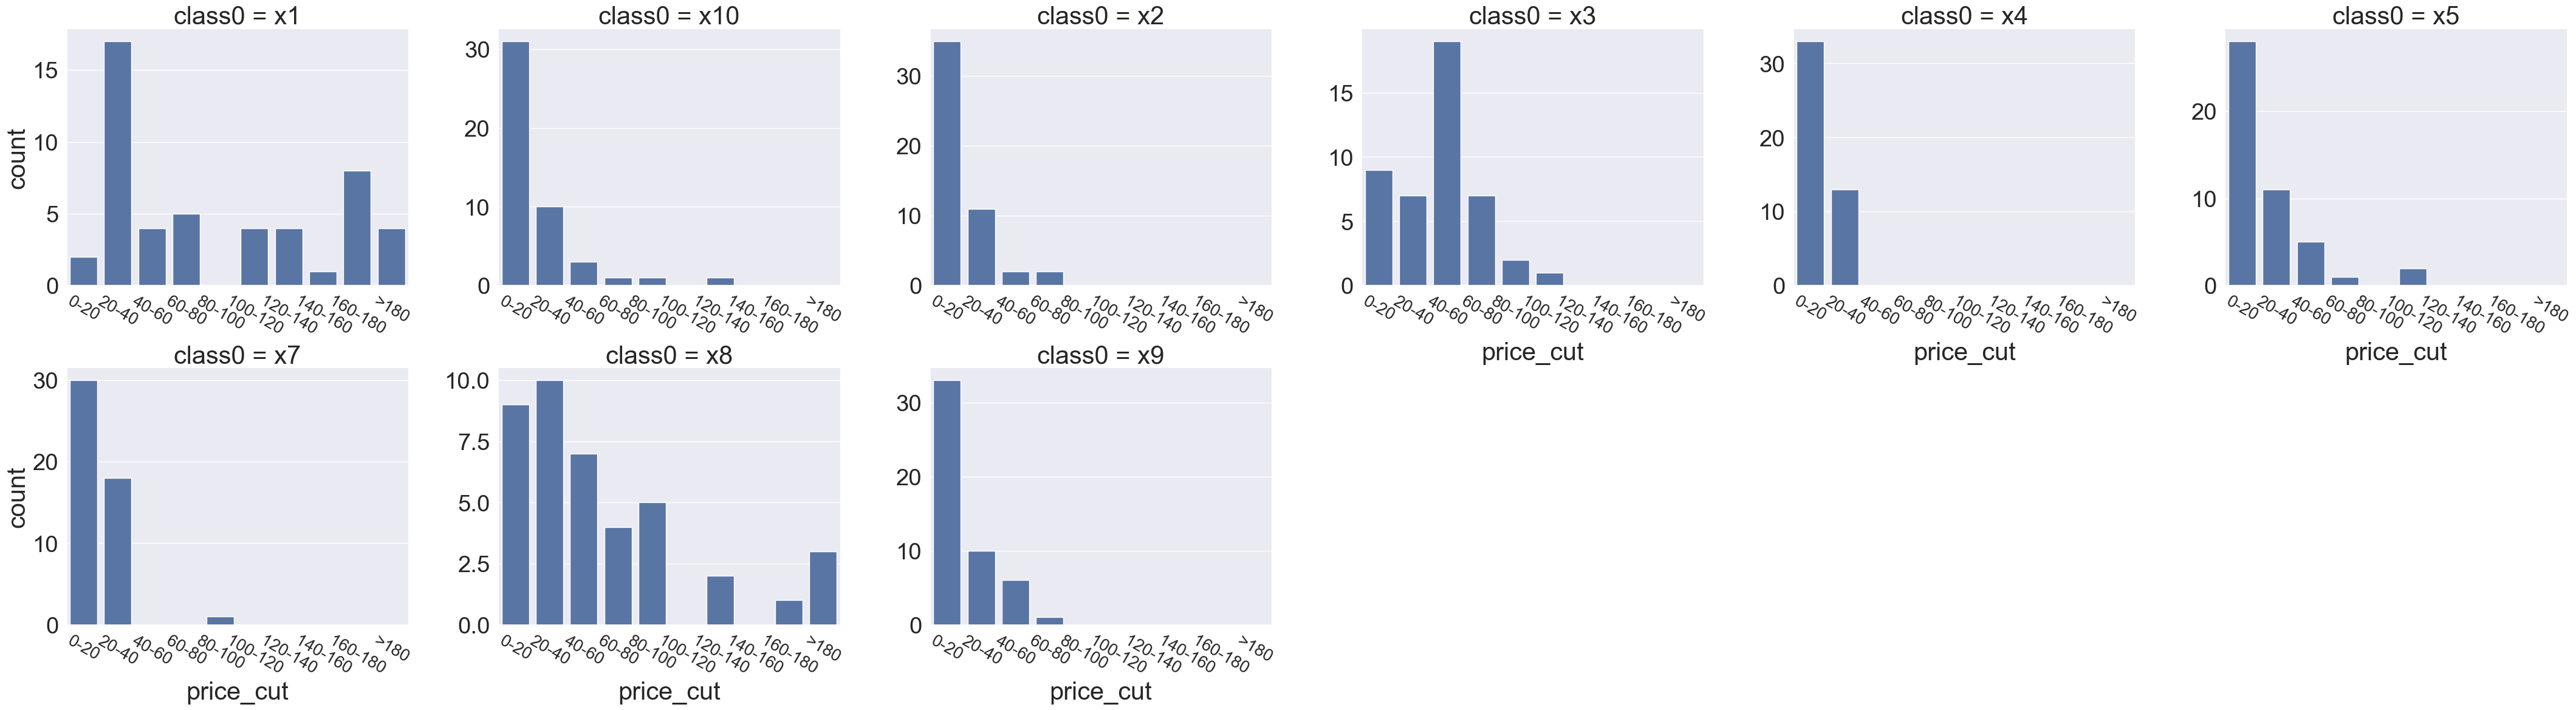

In [13]:
reviews_class=df_clean.groupby(['class0','price_cut'],as_index=False)['reviews'].agg(['count']).reset_index()
# FacetGrid 
g=sns.FacetGrid(data=reviews_class,col='class0',col_wrap=6,sharex=False,sharey=False,height=6,aspect=1.2)
g.map(sns.barplot,'price_cut','count')
g.set_xticklabels(fontsize=20, rotation=-30)

In [14]:
reviews_class=df_clean.groupby(['class0','price_cut'],as_index=False)['reviews'].agg(['count']).reset_index()    #just class0

In [15]:
sample=df_clean[df_clean.class0=='x1']
n=sample['price_cut']
counts=n.value_counts(ascending=False)
name=n.value_counts(ascending=False).index[0]
num=counts.values[0]
ratio=num/sum(counts)

In [16]:
def get_most_count2(n):
    counts=n.value_counts(ascending=False)
    name=n.value_counts(ascending=False).index[0]
    num = n.value_counts(ascending=False).values[0]
    r = num / sum(counts)
    return name, num, r

In [17]:
def get_quantile(n):
    return list(n.quantile([0, 0.2, 0.5, 0.8, 1]))

In [18]:
feature={
        'price_cut_n':get_most_count2,
        'price':['mean','median','max','min',get_quantile]}
df_clean[['price','stars','reviews']]=df_clean[['price','stars','reviews']].apply(pd.to_numeric)
df_sample=df_clean.groupby('class0').agg(feature)
df_sample.head()

price_cut_n      price                         \
                    get_most_count2       mean median      max    min   
class0                                                                  
x1      (2, 17, 0.3469387755102041)  94.396531  69.87  280.490  18.56   
x10     (1, 31, 0.6595744680851063)  23.848404  16.87  126.965   4.05   
x2                     (1, 35, 0.7)  21.202200  16.48   67.990   7.58   
x3      (3, 19, 0.4222222222222222)  44.954222  44.01  111.670   4.79   
x4       (1, 33, 0.717391304347826)  16.208913  16.99   38.990   2.49   

                                                           
                                             get_quantile  
class0                                                     
x1                 [18.56, 31.596, 69.87, 170.75, 280.49]  
x10     [4.05, 11.91, 16.87, 33.330000000000005, 126.965]  
x2                   [7.58, 12.704, 16.48, 26.048, 67.99]  
x3      [4.79, 22.392000000000003, 44.01, 65.302, 111.67]  
x4                      [2.49, 7.99, 16.99, 21.99, 38.99]

In [19]:
def get_info(df):
    df[['price', 'stars', 'reviews']] = df[['price', 'stars', 'reviews']].apply(pd.to_numeric)

    # count each brand number on different class
    b1 = df['brand'].value_counts()
    b2 = df['brand'].value_counts(normalize=True)

    #Processing for each category of numerical data and discretized numerical data
    #Statistical indicators for discretized numerical data, this processing method utilizes pandas' agg function
    #Concentration
    def get_most_count2(n):
        counts = n.value_counts(ascending=False)
        name = n.value_counts(ascending=False).index[0]
        num = n.value_counts(ascending=False).values[0]
        r = num / sum(counts)
        return name, num, r

    def get_quantile(n):
        return list(n.quantile([0, 0.2, 0.5, 0.8, 1]))

    feature = {
        'class0': 'count',
        'price_cut_n': get_most_count2,
        'price': ['mean', 'median', 'max', 'min', get_quantile],
        'reviews_cut_n': get_most_count2,
        'reviews': ['mean', 'median', 'max', 'min', get_quantile],
        'stars_cut_n': get_most_count2,
        'stars': ['mean', 'median', 'max', 'min', get_quantile],
        'rank_big_cut_n': get_most_count2,
        'rank_big': ['mean', 'median', 'max', 'min', get_quantile]
    }

    df_all = df.groupby(['class0']).agg(feature)

    # top10
    df_top10 = df[df.rank1_list_cut == '<=10'].groupby(['class0']).agg(feature)

    # Further data processing, combining data for each category into one row.
    def get_feature(df, n):
        df_new = df.copy()
        # Custom Transformation Process
        for col_num, col_name in enumerate(df):
            # Flatten and Find Corresponding Columns
            if col_name in [('price_cut_n', 'get_most_count2'), ('reviews_cut_n', 'get_most_count2'),
                            ('stars_cut_n', 'get_most_count2'), ('rank_big_cut_n', 'get_most_count2')]:
                # Separate Lists and Tuples in this Column
                p = df[col_name].apply(pd.Series)
                
                # rename
                p.columns = [col_name[0] + '_most', col_name[0] + '_most_count', col_name[0] + '_most_ratio']
                # Remove the old data represented using tuples and merge the new data, which is divided into multiple columns
                df_new = pd.concat([df_new.drop(col_name, axis=1), p], axis=1)
            elif col_name in [('rank_big', 'get_quantile'), ('price', 'get_quantile'), ('reviews', 'get_quantile'),('stars', 'get_quantile')]:
                p2 = df[col_name].apply(pd.Series)
                p2.columns = [col_name[0] + '_0', col_name[0] + '_20', col_name[0] + '_40', col_name[0] + '_80',
                              col_name[0] + '_100']
                df_new = pd.concat([df_new.drop(col_name, axis=1), p2], axis=1)
        name = []
        for i in df_new.columns:
            if isinstance(i, tuple):
                name.append(i[0] + '-' + i[1])
            else:
                name.append(i)
        df_new.columns = [i + n for i in name]
        return df_new

        # connect
    print(df_top10.info)
    dd = get_feature(df_top10, '_top_10')

    dd1 = get_feature(df_all, '_top_50')
    final = pd.concat([dd, dd1], axis=1)

    #Adding additional information
    #Number of Amazon deliveries for a certain category
    final['amz'] = len(df[df.delivery == 'Ships from and sold by Amazon.com.']) / len(df)
    final['delivery'] = len(df[df['delivery'].str.contains('Fulfilled by Amazon')]) / len(df)

    # how many brands
    final['brand_count'] = len(b1)
    final['brand_top_ratio'] = b2[0]

    final['r_p'] = np.mean(df['r_p'])
    # print(final)
    return final

df_clean['class1']=df_clean['class0'].copy()
df_featrue=df_clean.groupby(['class1']).apply(get_info).reset_index()
df_featrue.index=df_featrue['class0']

rank_bins=[0,500,1000,5000,10000,50000,100000,10000000]
df_featrue['rank_big_cut_n_most_top_10']

<bound method DataFrame.info of        class0     price_cut_n   price                       \
        count get_most_count2    mean median    max    min   
class0                                                       
x1         10     (2, 6, 0.6)  72.516  33.99  180.0  29.99   

                                                           reviews_cut_n  \
                                            get_quantile get_most_count2   
class0                                                                     
x1      [29.99, 29.99, 33.99, 146.81799999999998, 180.0]     (1, 2, 0.2)   

       reviews         ...  stars                                        \
          mean median  ... median  max  min                get_quantile   
class0                 ...                                                
x1      1143.4  234.5  ...    4.2  4.4  3.8  [3.8, 3.88, 4.2, 4.4, 4.4]   

        rank_big_cut_n rank_big                          \
       get_most_count2     mean  median      max    mi

class0
x1     3.0
x10    3.0
x2     5.0
x3     4.0
x4     3.0
x5     4.0
x7     4.0
x8     8.0
x9     5.0
Name: rank_big_cut_n_most_top_10, dtype: float64

In [20]:
#market demand
market_demond_list=['rank_big_cut_n_most_top_10','rank_big_80_top_50']
#market competition
market_chan_list=['reviews-median_top_50','reviews_cut_n_most_top_10','brand_count','brand_top_ratio']
#product related
product_info_list=['amz','delivery','stars_cut_n_most_top_10','stars-mean_top_50','r_p','price-median_top_50','price_cut_n_most_top_10','price_80_top_10']
df_final=df_featrue[market_chan_list+market_demond_list+product_info_list]

df_final

,reviews-median_top_50,reviews_cut_n_most_top_10,brand_count,brand_top_ratio,rank_big_cut_n_most_top_10,rank_big_80_top_50,amz,delivery,stars_cut_n_most_top_10,stars-mean_top_50,r_p,price-median_top_50,price_cut_n_most_top_10,price_80_top_10
class0,,,,,,,,,,,,,,
x1,57.0,1.0,31,0.081633,3.0,82578.1,0.000000,0.897959,5.0,3.993878,27.367347,69.870,2.0,146.818
x10,21.0,6.0,23,0.234043,3.0,69593.0,0.382979,0.382979,5.0,4.212766,10.680851,16.870,1.0,32.670
x2,207.0,4.0,26,0.180000,5.0,12997.8,0.380000,0.620000,5.0,4.118000,7.020000,16.480,1.0,17.374
x3,99.0,4.0,15,0.266667,4.0,82062.2,0.177778,0.488889,5.0,3.893333,15.000000,44.010,3.0,41.790
x4,5.0,7.0,37,0.130435,3.0,150587.0,0.086957,0.652174,5.0,3.241304,8.500000,16.990,1.0,19.894
x5,308.0,1.0,20,0.319149,4.0,14047.4,0.212766,0.787234,5.0,4.410638,6.936170,15.990,1.0,32.990
x7,79.0,4.0,32,0.204082,4.0,26855.2,0.346939,0.591837,5.0,4.677551,8.142857,19.500,2.0,30.202
x8,4.0,7.0,22,0.146341,8.0,343985.0,0.121951,0.317073,5.0,3.587805,24.341463,47.650,3.0,75.790
x9,220.5,4.0,17,0.360000,5.0,17161.8,0.400000,0.420000,5.0,4.348000,6.760000,13.225,1.0,16.526


In [21]:

data=df_final.copy()
#reverse
def get_inverse(n):
    return -n

In [22]:
#Indicator Alignment
data[['amz','brand_count','brand_top_ratio','reviews-median_top_50','reviews_cut_n_most_top_10']]=data[['amz','brand_count','brand_top_ratio','reviews-median_top_50','reviews_cut_n_most_top_10']].apply(get_inverse)
print(data)

        reviews-median_top_50  reviews_cut_n_most_top_10  brand_count  \
class0                                                                  
x1                      -57.0                       -1.0          -31   
x10                     -21.0                       -6.0          -23   
x2                     -207.0                       -4.0          -26   
x3                      -99.0                       -4.0          -15   
x4                       -5.0                       -7.0          -37   
x5                     -308.0                       -1.0          -20   
x7                      -79.0                       -4.0          -32   
x8                       -4.0                       -7.0          -22   
x9                     -220.5                       -4.0          -17   

        brand_top_ratio  rank_big_cut_n_most_top_10  rank_big_80_top_50  \
class0                                                                    
x1            -0.081633                       

In [23]:
minmax_scaler=preprocessing.MinMaxScaler()
data_scale=minmax_scaler.fit_transform(data)
data_scale=pd.DataFrame(data_scale,columns=data.columns)
data_scale.index=data.index

In [24]:
market_demond = 0.3
market_chan = 0.4
product_info = 0.3
weight_dict = {
    # sumup is 1
    'rank_big_cut_n_most_top_10': market_demond * 0.6,
    'rank_big_80_top_50': market_demond * 0.4,

    # sumup is 1
    'reviews-median_top_50': market_chan * 0.2,
    'reviews_cut_n_most_top_10': market_chan * 0.3,
    'brand_count': market_chan * 0.3,
    'brand_top_ratio': market_chan * 0.2,

    # sumup is 1
    'amz': product_info * 0.2,
    'delivery': product_info * 0.05,
    'stars_cut_n_most_top_10': product_info * 0.05,
    'stars-mean_top_50': product_info * 0.05,
    'r_p': product_info * 0.3,
    'price-median_top_50': market_demond * 0.05,
    'price_cut_n_most_top_10': market_demond * 0.2,
    'price_80_top_10': market_demond * 0.1
}

In [25]:
# give different weight
W1 = pd.DataFrame(weight_dict, index=['expert_w']).T

In [26]:
def entropy(df1):
    df = df1.copy()
    n = list(df.columns)

    # Build the data proportion matrix p
    for i in n:
        # Calculate the total sum of the indicator
        Sum = np.sum(df[i])
        # Calculate the proportion of each data for a specific indicator
        df[i] = df[i] / Sum

    # Calculate the information entropy and information utility value d for each indicator
    m = len(df)
    E = []
    
    # Calculate the information entropy value
    for i in n:
        K = 1 / np.log(m)
        e = -K * np.sum(df[i] * np.log(df[i]))
        E.append(e)

    # Convert to array form
    E = np.array(E)

    # Calculate the utility value
    D = 1 - E

    # Calculate the indicator weights
    W = D / np.sum(D)

    # Convert to array form
    W = np.array([W])

    # Save the results as a DataFrame
    W1 = pd.DataFrame(W.T, index=n)
    W1.columns = ['entropy_w']

    return W1

W2 = entropy(data_scale)
W_final = W1.join(W2)
W_final.info


<bound method DataFrame.info of                             expert_w  entropy_w
rank_big_cut_n_most_top_10     0.180   0.072816
rank_big_80_top_50             0.120   0.086865
reviews-median_top_50          0.080   0.022827
reviews_cut_n_most_top_10      0.120   0.043375
brand_count                    0.120   0.025301
brand_top_ratio                0.080   0.026712
amz                            0.060   0.051151
delivery                       0.015   0.034492
stars_cut_n_most_top_10        0.015   0.260589
stars-mean_top_50              0.015   0.021585
r_p                            0.090   0.087439
price-median_top_50            0.015   0.078589
price_cut_n_most_top_10        0.060   0.102892
price_80_top_10                0.030   0.085367>

In [27]:
def get_score(df,name,weight='entropy_w',col='final_score'):
    
    t1=df[name]
    print('这是t1',t1)

    #weight system
    W=W_final.loc[name,weight]
    print(W)
    W=np.array(W)
    #calculate and save score
    U=[]
    for i in range(1,len(t1)+1):
        # get all indicator value
        y=t1[i-1:i].values
        # total score
        u=np.sum(y*W)*100
        U.append(u)
    U=pd.DataFrame(U,index=list(t1.index))
    print(U)
    U.columns=[col]
    U[col+' rank']=U[col].rank(ascending=False)
    return U

In [28]:
#final score
data_final=get_score(data_scale,market_demond_list,'expert_w','score_market_demond')
data_final=data_final.join(get_score(data_scale,market_chan_list,'expert_w','score_market_chan'))
data_final=data_final.join(get_score(data_scale,product_info_list,'expert_w','score_product_info'))
data_final['score']=data_final['score_market_demond']+data_final['score_market_chan']+data_final['score_product_info']
#get highest rank
data_final['rank']=data_final['score'].rank(ascending=False)

data_final.sort_values('rank')

这是t1         rank_big_cut_n_most_top_10  rank_big_80_top_50
class0                                                
x1                             0.0            0.210221
x10                            0.0            0.170989
x2                             0.4            0.000000
x3                             0.2            0.208662
x4                             0.0            0.415693
x5                             0.2            0.003171
x7                             0.2            0.041867
x8                             1.0            1.000000
x9                             0.4            0.012581
rank_big_cut_n_most_top_10    0.18
rank_big_80_top_50            0.12
Name: expert_w, dtype: float64
             0
x1    2.522646
x10   2.051869
x2    7.200000
x3    6.103942
x4    4.988321
x5    3.638053
x7    4.102403
x8   30.000000
x9    7.350967
这是t1         reviews-median_top_50  reviews_cut_n_most_top_10  brand_count  \
class0                                                       

,score_market_demond,score_market_demond rank,score_market_chan,score_market_chan rank,score_product_info,score_product_info rank,score,rank
x8,30.000000,1.0,22.322151,4.0,20.487261,2.0,72.809412,1.0
x1,2.522646,8.0,29.877990,1.0,24.785979,1.0,57.186616,2.0
x3,6.103942,4.0,26.182307,2.0,15.453612,3.0,47.739862,3.0
x5,3.638053,7.0,22.446746,3.0,5.773075,6.0,31.857874,4.0
x7,4.102403,6.0,19.234527,7.0,7.090435,4.0,30.427364,5.0
x2,7.200000,3.0,19.830915,6.0,2.217119,8.0,29.248035,6.0
x9,7.350967,2.0,19.211722,8.0,1.421605,9.0,27.984294,7.0
x10,2.051869,9.0,20.808887,5.0,3.620712,7.0,26.481468,8.0
x4,4.988321,5.0,14.571160,9.0,6.498142,5.0,26.057623,9.0
